#### Comparison of an Inverse Filtering and Wiener Filtering for Image Motion Deblurring and Noise Reduction 
#### This report contains the source code, parameters, and results of the image restoration project. 

In [1]:
__author__ = "Elaheh Barati"
__email__ = "elaheh@wayne.edu"
__status__ = "Digital Image Processing and Analysis"

In [2]:
import numpy as np
import skimage.util.noise as noise
from numpy.fft import fft2, ifft2, fftshift
from pylab import *
import io
from scipy.signal import wiener
import skimage

class imageRestoration(object):

    def __init__(self):
        pass

    def degrade(self,img):
        noisy_img = noise.random_noise(img,'gaussian')
        F = fftshift(fft2(noisy_img))
        H = self.degrad_function(img)
        G = F*H
        g = abs(ifft2(G))
        self.show_image(g, 'Degraded image')
        return G,g

    def inverse_filter(self,d_img):
        G = fftshift(fft2(d_img))
        H = self.degrad_function(d_img)
        inv_F = G/H
        inv_g = abs(ifft2(inv_F))
        self.show_image(inv_g,'Restored image with Inverse filter with transformation between spatial and frequency domain')
        
    def inverse_filter_fft(self,d_img,G):
        H = self.degrad_function(d_img)
        inv_F = G/H
        inv_g = abs(ifft2(inv_F))
        self.show_image(inv_g,'Restored image with Inverse filter without transformation between spatial and frequency domain')

    def wiener_filter(self, img,G):
        H = self.degrad_function(img)
        conj_ = np.conjugate(H)
        power_spectrum_H  = H * conj_
        power_spectrum_noise = 1
        power_spectrum_undeg_img = (np.abs(fftshift(fft2(img))))**2
        power_spectrum_undeg_img = 10*np.log10(power_spectrum_undeg_img)
        k = power_spectrum_noise/power_spectrum_undeg_img
        print("k = ", k)
        wiener_F = ((1/H)*power_spectrum_H/(power_spectrum_H+k))*G
        wiener_f = abs(ifft2(wiener_F))
        self.show_image(wiener_f,'Restored image with Wiener filter')


    def degrad_function(self,img):
        height, width = img.shape[:2]
        [U, V] = np.mgrid[-width / 2:width / 2, -height / 2:height / 2]
        H = self.transfer(U, V, 0.1, 0.1, 1)
        return H

    def transfer(self,u , v, a, b, T):
        uavb = u*a+v*b+ np.spacing(1)
        return T/(np.pi*(uavb))*np.sin(np.pi*(uavb))*np.exp(-1j*np.pi*(uavb))

    def dftuv(self,M, N):
        u = range(0, M)
        v = range(0, N)
        idx = [x for x in u if x > M/2]
        for i in idx:
            u[i] = u[i] - M
        idy = [y for y in v if y > N/2]
        for i in idy:
            v[i] = v[i] - N
        [V, U] = meshgrid(v, u)
        return [V, U]

    def plot_spectrum(self, img):
        height, width = img.shape[:2]
        [U, V] = np.mgrid[-width/2:width/2, -height/2:height/2]
        H = self.transfer(U, V, 0.1, 0.1, 1)
        H = fftshift(H)
        pow_of_spectrum = np.log10(np.abs(H) + 1)
        im = imshow(pow_of_spectrum, cmap=cm.RdBu)
        colorbar(im)
        title('Spectrum')
        show()

    def show_image(self, img, pic_title):
        imshow(img, cmap = cm.binary)
        title(pic_title)
        show() 

##### Given an image named 'imageforhw3.jpg', it is illustrated in the following.

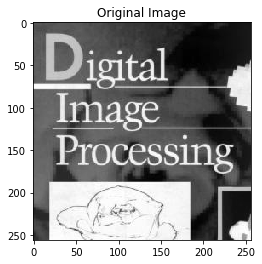

In [3]:
imgRes = imageRestoration()
img = imread('img.jpg')
imgRes.show_image(img,'Original Image')

###### The image is degraded according the following motion model,
$$g(x,y) = \int_{0}^{T}f[x-x_0(t), y-y_0(t)]dt + \eta (x,y)$$

###### From the Fourier transform of the ebove Eq., we can obtain the motion degradation function in frequency domain. 
$$G(u,v) = \int \int g(x,y)e^{-j2\pi [ux+vy]}dxdy$$
$$G(u,v) = \int \int [ \int_{0}^{T}f[x-x_0(t), y-y_0(t)]dt + \eta (x,y)]e^{-j2\pi [ux+vy]}dxdy$$
$$G(u,v) = \int \int [ \int_{0}^{T}f[x-x_0(t), y-y_0(t)]dt] e^{-j2\pi [ux+vy]}dxdy+\int \int \eta (x,y) e^{-j2\pi [ux+vy]}dxdy$$
$$G(u,v) =  \int_{0}^{T}[\int \int f[x-x_0(t),y-y_0(t)]e^{-j2\pi (ux+vy)dxdy}]dt + Z(u,v)$$

$$G(u,v) = \int_{0}^{T}F(u,v)e^{-j2\pi [ux_0(t)+vy_0(t)]}dt + Z(u,v)$$ 

###### we know that $F(u,v)$ is independent of t. Therefore, 
$$G(u,v) = F(u,v)\int_{0}^{T}e^{-j2\pi [ux_0(t)+vy_0(t)]}dt + Z(u,v)$$ 

##### By defining 
$$H(u,v) = \int_{0}^{T}e^{-j2\pi [ux_0(t)+vy_0(t)]}dt$$ 

###### we can get : $$ G(u,v) = H(u,v)F(u,v)+Z(u,v)$$

###### Since we have some functions $x_0(t), y_0(t)$, where $x_0(0)=0 , y_0(0)=0, x_0(T)=a, y_0(T)=b $, 
###### Therefore: $x_0(t)=\frac{a}{T}t$ and $y_0(t)=\frac{b}{T}t$

$$H(u,v) = \frac{T}{\pi (ua+vb)}\sin[\pi(ua+vb)]e^{-j\pi(ua+vb)}$$

###### In the following the spectrum of $H(u,v)$ is illustrated. 

###### based on the fact that $G(u,v) = H(u,v)F(u,v)$, we calculate $G(u,v)$ for $a=b=0.1$ and $T=1$ in $H(u,v)$
###### we can obtain $g(u,v)$ by applying Inverse Fourier Transform on $G(u,v)$

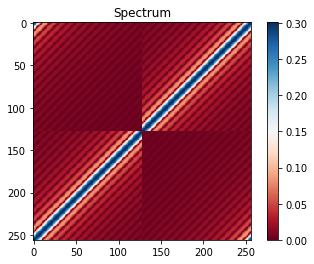

In [4]:
imgRes.plot_spectrum(img)

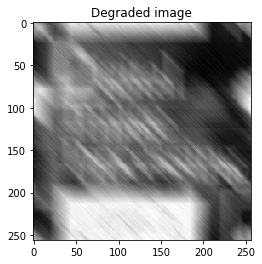

In [5]:
G, d_img = imgRes.degrade(img)

###### We designed and applied inverse filter to the degraded image two times. 
$$ \widehat{F}(u,v)= \frac{G(u,v)}{H(u,v)} $$
- using tranformation
    In this part, we used the degraded image in the spatial domain. Therefore, we need to tranform it into the frequency domain. As you can see, iifft2 and fft2 introduce some rounding noise that cause serious problems. 
- without transformation
    In this part, we used the degraded image in the frequency domain. It is observed that the result is better than the previous model. 
The resotred imgage is shown in the following.

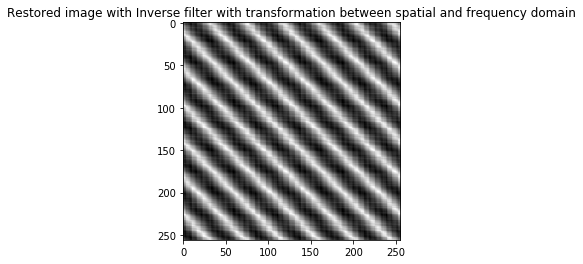

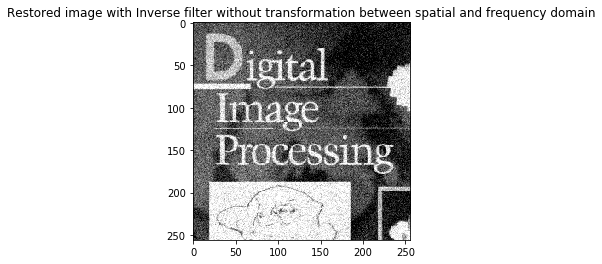

In [6]:
imgRes.inverse_filter(d_img)
imgRes.inverse_filter_fft(d_img,G)

###### We designed and applied wiener filter to the degraded image. 
$$\widehat{F}(u,v)= [\frac{1}{H(u,v)}\frac{\left | H(u,v) \right |^2}{\left | H(u,v) \right |^2+S_{\eta }(u,v)/S_f(u,v)}]G(u,v) $$

We estimate $k$ based on the power spectrum of the noise and power spectrum of undegraded image 
$K= S_{\eta }(u,v)/S_f(u,v)$

k =  [[0.02095903 0.0176964  0.01923969 ... 0.01922418 0.01923969 0.0176964 ]
 [0.01719307 0.01894472 0.0178813  ... 0.01627451 0.01992369 0.01872657]
 [0.01823712 0.01910472 0.01753023 ... 0.01749915 0.02142956 0.03161245]
 ...
 [0.02089148 0.01785106 0.01877456 ... 0.01846407 0.01884845 0.01681583]
 [0.01823712 0.03161245 0.02142956 ... 0.01718044 0.01753023 0.01910472]
 [0.01719307 0.01872657 0.01992369 ... 0.01704596 0.0178813  0.01894472]]


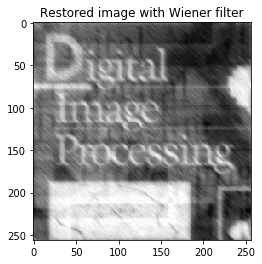

In [7]:
imgRes.wiener_filter(img, G)